<a href="https://colab.research.google.com/github/shanikairoshi/Communication-Efficient-DUQFL/blob/main/main_v2_1.4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# %%capture
!pip install genomic-benchmarks
!pip install qiskit qiskit_machine_learning qiskit_algorithms qiskit-aer




In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import sys
from pathlib import Path
PROJ = Path.cwd() / "tduqfl_Project_AGG"
if str(PROJ) not in sys.path:
    sys.path.insert(0, str(PROJ))
import sys
sys.path.append('/content/drive/MyDrive/Teleportation/tduqfl_Project_AGG/tDuQFL_Project')
# ─── 5. Assemble filenames for each artifact ─────────────────────────────────
#drive_root = "/content/drive/MyDrive/Teleportation/tduqfl_Project_AGG/tDuQFL_Project/"

In [4]:
from common.imports import *
from configs.dataset_genome_iid import *     # swap to other configs as needed
from io_utils.naming import stamp_now, flags, build_param_str, make_filenames

start_str, date_str = stamp_now()
teleport_pl, noise_pl = flags(use_teleportation, use_noise)
param_str = build_param_str(num_clients, num_federated_layers, num_deep_unfolding_iterations,
                            initial_learning_rate, initial_perturbation)

best_client_csv_file, global_csv_file, local_csv_file, validation_csv_file = make_filenames(
    drive_root, dataset_name, split_type, date_str, teleport_pl, noise_pl, param_str
)
from io_utils.csv_logger import init_local_csv, init_best_csv, init_validation_csv

# Create folders + write headers
init_best_csv(best_client_csv_file)

local_headers = [
    "Federated Round", "Client Number", "Iteration",
    "Objective Function Value", "Training Accuracy", "Test Accuracy",
    "Learning Rate", "Perturbation"
]
init_local_csv(local_csv_file, local_headers)

init_validation_csv(validation_csv_file)

# Do NOT pre-init global_csv_file here because your save_accuracies_to_csv()
# already writes the header each time it runs (in 'w' mode).

/usr/local/lib/python3.12/dist-packages/genomic_benchmarks/utils/datasets.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Python: 3.12.11 (main, Jun  4 2025, 08:56:18) [GCC 11.4.0]
Qiskit: 1.4.4
qiskit_aer available?: True


Load and Split data

In [5]:
from data.preprocess_genome import load_and_prepare_dataset
from data.splitters import split_dataset_for_epochs
from configs.base_config import (
    num_clients, num_epochs, samples_per_epoch, split_type,
    global_seed
)

np_train_data, np_test_data = load_and_prepare_dataset(word_size, global_seed)

# 2) Compute feasible epoch capacity and cap both epochs and rounds
N_train = len(np_train_data)
train_capacity = N_train // (num_clients * samples_per_epoch)
num_epochs_eff = max(1, min(num_epochs, train_capacity))

if train_capacity == 0:
    raise ValueError(
        f"Not enough training samples ({N_train}) for "
        f"{num_clients=} × {samples_per_epoch=} per epoch. "
        "Reduce samples_per_epoch or num_clients, or enable resampling."
    )

num_federated_layers_eff = min(num_federated_layers, num_epochs_eff)

# Build clients
if split_type.lower() == "iid":
    from data.splitters import split_dataset_for_epochs
    clients = split_dataset_for_epochs(
        num_clients=num_clients,
        num_epochs=num_epochs_eff,             # or num_epochs
        train_data=np_train_data,
        test_data=np_test_data,
        samples_per_epoch=samples_per_epoch,
    )
elif split_type.lower() in {"noniid", "non-iid", "non_iid"}:
    from data.noniid import make_non_iid_clients
    clients = make_non_iid_clients(
        train_data=np_train_data,
        test_data=np_test_data,
        num_clients=num_clients,
        num_epochs=num_epochs_eff,             # or num_epochs
        samples_per_epoch=samples_per_epoch,
        non_iid_ratio=0.8,                     # tune as needed
        quantity_variation=0.5,                # tune as needed
        seed=global_seed,
        plot=True
    )
else:
    raise ValueError(f"Unknown split_type: {split_type}")

'''
clients = split_dataset_for_epochs(
    num_clients=num_clients, num_epochs=num_epochs,
    train_data=np_train_data, test_data=np_test_data,
    samples_per_epoch=samples_per_epoch
)
'''
# validation/tables
test_sequences = np.array([d["sequence"] for d in np_test_data])
test_labels    = np.array([d["label"]    for d in np_test_data])
X_val, y_val   = test_sequences, test_labels

# derive num_features once
if clients and clients[0].data and clients[0].data[0]:
    num_features = clients[0].data[0][0]['sequence'].shape[0]
else:
    raise RuntimeError("Empty client data – check splitting indices.")


In [6]:
# Infer num_features from the first available sample in clients
def infer_num_features_from_clients(clients):
    for c in clients:
        for epoch_data in c.data:              # list of samples for that epoch
            if not epoch_data:
                continue
            sample = epoch_data[0]
            if "sequence" in sample:           # your Genome pipeline
                arr = np.asarray(sample["sequence"])
                return int(arr.size)
            if "features" in sample:           # some other pipelines
                arr = np.asarray(sample["features"])
                return int(arr.size)
            if "image" in sample:              # e.g., MNIST before flatten
                arr = np.asarray(sample["image"]).reshape(-1)
                return int(arr.size)
            # add any other key you use
    raise RuntimeError("Could not infer num_features: no samples found.")

num_features = infer_num_features_from_clients(clients)
print(f"[info] num_features = {num_features}")


[info] num_features = 5


run federated loop and plot

Training Progress:   0%|          | 0/10 [00:00<?, ?it/s]

[Round 0] Teleportation OFF | Aggregation=best
[round 0 | client 0] seed LR=0.1400000000 (prev=0.1400000000), seed PERT=0.1400000000 (prev=0.1400000000), gamma=0.50


Deep Unfolding Iteration 1/5
[meta] cb#005 loss=0.466943 step=0.03986 g_raw=+0.015 g_sm=+0.003 acc=1 | LR→0.140280 PERT→0.140000 (scale=0.04)
[meta] cb#010 loss=0.461107 step=0.02988 g_raw=+0.018 g_sm=+0.006 acc=1 | LR→0.140561 PERT→0.140000 (scale=0.04)
[meta] cb#015 loss=0.455328 step=0.07372 g_raw=+0.027 g_sm=+0.009 acc=1 | LR→0.140843 PERT→0.140000 (scale=0.04)
[meta] cb#020 loss=0.451342 step=0.01499 g_raw=+0.008 g_sm=+0.010 acc=1 | LR→0.141125 PERT→0.140001 (scale=0.04)
[meta] cb#025 loss=0.445726 step=0.05176 g_raw=+0.018 g_sm=+0.012 acc=1 | LR→0.141408 PERT→0.140001 (scale=0.04)
[client 0 | unfold 1] LR_used=0.1400000000, PERT_used=0.1400000000 → LR_next=0.1414080338, PERT_next=0.1400010004
[meta-summary] callbacks=25 g_raw_mean=+0.016 g_sm_mean=+0.007 acc_ratio=1.00 | LR 0.1400000000→0.1414080338 PERT 0.140000000

Training Progress:  10%|█         | 1/10 [09:00<1:21:00, 540.06s/it]

[Round   0] acc_g=0.729 (μ=0.707, σ=0.057, FG=0.123) | t=530.112s, val=0.543 | TEL=FALSE
[Round 1] Teleportation OFF | Aggregation=best
[round 1 | client 0] seed LR=0.1435932558 (prev=0.1471865115), seed PERT=0.1400040703 (prev=0.1400081407), gamma=0.50


Deep Unfolding Iteration 1/5
[meta] cb#005 loss=0.502480 step=0.02179 g_raw=+0.009 g_sm=+0.004 acc=1 | LR→0.143881 PERT→0.140004 (scale=0.04)
[meta] cb#010 loss=0.497435 step=0.0811 g_raw=+0.029 g_sm=+0.007 acc=1 | LR→0.144169 PERT→0.140004 (scale=0.04)
[meta] cb#015 loss=0.492035 step=0.1016 g_raw=+0.038 g_sm=+0.009 acc=1 | LR→0.144458 PERT→0.140004 (scale=0.04)
[meta] cb#020 loss=0.483584 step=0.002795 g_raw=+0.001 g_sm=+0.012 acc=1 | LR→0.144747 PERT→0.140005 (scale=0.04)
[meta] cb#025 loss=0.481949 step=0.04932 g_raw=+0.016 g_sm=+0.011 acc=1 | LR→0.145037 PERT→0.140005 (scale=0.04)
[client 0 | unfold 1] LR_used=0.1435932558, PERT_used=0.1400040703 → LR_next=0.1450374578, PERT_next=0.1400050992
[meta-summary] callbacks=25 g_raw_mea

Training Progress:  20%|██        | 2/10 [18:18<1:13:24, 550.60s/it]

[Round   1] acc_g=0.771 (μ=0.720, σ=0.130, FG=0.281) | t=547.985s, val=0.549 | TEL=FALSE
[Round 2] Teleportation OFF | Aggregation=best
[round 2 | client 0] seed LR=0.1454818453 (prev=0.1509636905), seed PERT=0.1400058614 (prev=0.1400117228), gamma=0.50


Deep Unfolding Iteration 1/5
[meta] cb#005 loss=0.522803 step=0.06445 g_raw=+0.023 g_sm=+0.004 acc=1 | LR→0.145773 PERT→0.140006 (scale=0.04)
[meta] cb#010 loss=0.518119 step=0.01102 g_raw=-0.001 g_sm=+0.006 acc=1 | LR→0.146065 PERT→0.140006 (scale=0.04)
[meta] cb#015 loss=0.513734 step=0.01109 g_raw=+0.005 g_sm=+0.008 acc=1 | LR→0.146358 PERT→0.140006 (scale=0.04)
[meta] cb#020 loss=0.511677 step=0.03366 g_raw=+0.012 g_sm=+0.009 acc=1 | LR→0.146651 PERT→0.140007 (scale=0.04)
[meta] cb#025 loss=0.505963 step=0.009655 g_raw=+0.003 g_sm=+0.010 acc=1 | LR→0.146945 PERT→0.140007 (scale=0.04)
[client 0 | unfold 1] LR_used=0.1454818453, PERT_used=0.1400058614 → LR_next=0.1469449478, PERT_next=0.1400068006
[meta-summary] callbacks=25 g_raw_m

Training Progress:  30%|███       | 3/10 [27:21<1:03:51, 547.38s/it]

[Round   2] acc_g=0.782 (μ=0.690, σ=0.084, FG=0.174) | t=533.779s, val=0.560 | TEL=FALSE
[Round 3] Teleportation OFF | Aggregation=best
[round 3 | client 0] seed LR=0.1464752445 (prev=0.1529504889), seed PERT=0.1400073385 (prev=0.1400146769), gamma=0.50


Deep Unfolding Iteration 1/5
[meta] cb#005 loss=0.521531 step=0.03438 g_raw=+0.011 g_sm=+0.002 acc=1 | LR→0.146769 PERT→0.140007 (scale=0.04)
[meta] cb#010 loss=0.518907 step=0.05999 g_raw=+0.022 g_sm=+0.004 acc=1 | LR→0.147062 PERT→0.140007 (scale=0.04)
[meta] cb#015 loss=0.511852 step=0.03943 g_raw=+0.016 g_sm=+0.008 acc=1 | LR→0.147357 PERT→0.140008 (scale=0.04)
[meta] cb#020 loss=0.497307 step=0.1283 g_raw=+0.053 g_sm=+0.013 acc=1 | LR→0.147652 PERT→0.140008 (scale=0.04)
[meta] cb#025 loss=0.494876 step=0.03223 g_raw=+0.013 g_sm=+0.013 acc=1 | LR→0.147948 PERT→0.140008 (scale=0.04)
[client 0 | unfold 1] LR_used=0.1464752445, PERT_used=0.1400073385 → LR_next=0.1479483765, PERT_next=0.1400083145
[meta-summary] callbacks=25 g_raw_mea

Training Progress:  40%|████      | 4/10 [36:29<54:46, 547.69s/it]  

[Round   3] acc_g=0.771 (μ=0.761, σ=0.104, FG=0.234) | t=538.205s, val=0.581 | TEL=FALSE
[Round 4] Teleportation OFF | Aggregation=best
[round 4 | client 0] seed LR=0.1469975458 (prev=0.1539950916), seed PERT=0.1400081702 (prev=0.1400163405), gamma=0.50


Deep Unfolding Iteration 1/5
[meta] cb#005 loss=0.480175 step=0.01374 g_raw=+0.005 g_sm=+0.001 acc=1 | LR→0.147292 PERT→0.140008 (scale=0.04)
[meta] cb#010 loss=0.472683 step=0.02096 g_raw=+0.008 g_sm=+0.005 acc=1 | LR→0.147587 PERT→0.140008 (scale=0.04)
[meta] cb#015 loss=0.468686 step=0.04812 g_raw=+0.017 g_sm=+0.008 acc=1 | LR→0.147882 PERT→0.140008 (scale=0.04)
[meta] cb#020 loss=0.462905 step=0.08201 g_raw=+0.031 g_sm=+0.010 acc=1 | LR→0.148179 PERT→0.140009 (scale=0.04)
[meta] cb#025 loss=0.456340 step=0.00751 g_raw=+0.003 g_sm=+0.012 acc=1 | LR→0.148476 PERT→0.140009 (scale=0.04)
[client 0 | unfold 1] LR_used=0.1469975458, PERT_used=0.1400081702 → LR_next=0.1484758096, PERT_next=0.1400090320
[meta-summary] callbacks=25 g_raw_me

Training Progress:  50%|█████     | 5/10 [45:37<45:38, 547.61s/it]

[Round   4] acc_g=0.614 (μ=0.746, σ=0.114, FG=0.218) | t=537.487s, val=0.623 | TEL=FALSE
[Round 5] Teleportation OFF | Aggregation=best
[round 5 | client 0] seed LR=0.1472712432 (prev=0.1545424864), seed PERT=0.1400078066 (prev=0.1400156133), gamma=0.50


Deep Unfolding Iteration 1/5
[meta] cb#005 loss=0.516013 step=0.07385 g_raw=+0.028 g_sm=+0.005 acc=1 | LR→0.147566 PERT→0.140008 (scale=0.04)
[meta] cb#010 loss=0.512654 step=0.04615 g_raw=+0.014 g_sm=+0.008 acc=1 | LR→0.147862 PERT→0.140008 (scale=0.04)
[meta] cb#015 loss=0.504329 step=0.02938 g_raw=+0.012 g_sm=+0.010 acc=1 | LR→0.148158 PERT→0.140008 (scale=0.04)
[meta] cb#020 loss=0.502406 step=0.01372 g_raw=+0.004 g_sm=+0.010 acc=1 | LR→0.148455 PERT→0.140009 (scale=0.04)
[meta] cb#025 loss=0.495818 step=0.08572 g_raw=+0.031 g_sm=+0.012 acc=1 | LR→0.148753 PERT→0.140009 (scale=0.04)
[client 0 | unfold 1] LR_used=0.1472712432, PERT_used=0.1400078066 → LR_next=0.1487525231, PERT_next=0.1400089166
[meta-summary] callbacks=25 g_raw_me

Training Progress:  60%|██████    | 6/10 [54:47<36:34, 548.63s/it]

[Round   5] acc_g=0.806 (μ=0.754, σ=0.068, FG=0.151) | t=540.535s, val=0.555 | TEL=FALSE
[Round 6] Teleportation OFF | Aggregation=best
[round 6 | client 0] seed LR=0.1474160242 (prev=0.1548320484), seed PERT=0.1400084462 (prev=0.1400168923), gamma=0.50


Deep Unfolding Iteration 1/5
[meta] cb#005 loss=0.538790 step=0.07164 g_raw=+0.022 g_sm=+0.003 acc=1 | LR→0.147711 PERT→0.140008 (scale=0.04)
[meta] cb#010 loss=0.533736 step=0.04373 g_raw=+0.016 g_sm=+0.006 acc=1 | LR→0.148007 PERT→0.140009 (scale=0.04)
[meta] cb#015 loss=0.531615 step=0.0007992 g_raw=+0.002 g_sm=+0.007 acc=1 | LR→0.148304 PERT→0.140009 (scale=0.04)
[meta] cb#020 loss=0.519377 step=0.01842 g_raw=+0.005 g_sm=+0.011 acc=1 | LR→0.148601 PERT→0.140009 (scale=0.04)
[meta] cb#025 loss=0.510207 step=0.1135 g_raw=+0.043 g_sm=+0.014 acc=1 | LR→0.148899 PERT→0.140009 (scale=0.04)
[client 0 | unfold 1] LR_used=0.1474160242, PERT_used=0.1400084462 → LR_next=0.1488986740, PERT_next=0.1400094750
[meta-summary] callbacks=25 g_raw_m

Training Progress:  70%|███████   | 7/10 [1:03:55<27:24, 548.16s/it]

[Round   6] acc_g=0.499 (μ=0.682, σ=0.086, FG=0.187) | t=537.411s, val=0.680 | TEL=FALSE
[Round 7] Teleportation OFF | Aggregation=best
[round 7 | client 0] seed LR=0.1474936843 (prev=0.1549873686), seed PERT=0.1400101691 (prev=0.1400203382), gamma=0.50


Deep Unfolding Iteration 1/5
[meta] cb#005 loss=0.492957 step=0.002101 g_raw=+0.001 g_sm=+0.002 acc=1 | LR→0.147789 PERT→0.140010 (scale=0.04)
[meta] cb#010 loss=0.488059 step=0.03309 g_raw=+0.013 g_sm=+0.005 acc=1 | LR→0.148085 PERT→0.140010 (scale=0.04)
[meta] cb#015 loss=0.471851 step=0.06369 g_raw=+0.028 g_sm=+0.012 acc=1 | LR→0.148382 PERT→0.140011 (scale=0.04)
[meta] cb#020 loss=0.457603 step=0.04633 g_raw=+0.020 g_sm=+0.015 acc=1 | LR→0.148679 PERT→0.140011 (scale=0.04)
[meta] cb#025 loss=0.450370 step=0.06595 g_raw=+0.023 g_sm=+0.017 acc=1 | LR→0.148977 PERT→0.140011 (scale=0.04)
[client 0 | unfold 1] LR_used=0.1474936843, PERT_used=0.1400101691 → LR_next=0.1489773874, PERT_next=0.1400114537
[meta-summary] callbacks=25 g_raw_m

Training Progress:  80%|████████  | 8/10 [1:13:00<18:14, 547.27s/it]

[Round   7] acc_g=0.523 (μ=0.699, σ=0.135, FG=0.298) | t=535.232s, val=0.633 | TEL=FALSE
[Round 8] Teleportation OFF | Aggregation=best
[round 8 | client 0] seed LR=0.1475332838 (prev=0.1550665677), seed PERT=0.1400099247 (prev=0.1400198493), gamma=0.50


Deep Unfolding Iteration 1/5
[meta] cb#005 loss=0.461078 step=0.01322 g_raw=+0.004 g_sm=+0.001 acc=1 | LR→0.147829 PERT→0.140010 (scale=0.04)
[meta] cb#010 loss=0.454417 step=0.05441 g_raw=+0.021 g_sm=+0.005 acc=1 | LR→0.148125 PERT→0.140010 (scale=0.04)
[meta] cb#015 loss=0.451436 step=0.01989 g_raw=+0.009 g_sm=+0.007 acc=1 | LR→0.148421 PERT→0.140010 (scale=0.04)
[meta] cb#020 loss=0.449922 step=0.01537 g_raw=+0.009 g_sm=+0.008 acc=1 | LR→0.148719 PERT→0.140010 (scale=0.04)
[meta] cb#025 loss=0.444163 step=0.07784 g_raw=+0.025 g_sm=+0.010 acc=1 | LR→0.149017 PERT→0.140011 (scale=0.04)
[client 0 | unfold 1] LR_used=0.1475332838, PERT_used=0.1400099247 → LR_next=0.1490168482, PERT_next=0.1400107047
[meta-summary] callbacks=25 g_raw_me

Training Progress:  90%|█████████ | 9/10 [1:22:07<09:07, 547.13s/it]

[Round   8] acc_g=0.679 (μ=0.750, σ=0.069, FG=0.148) | t=537.259s, val=0.595 | TEL=FALSE
[Round 9] Teleportation OFF | Aggregation=best
[round 9 | client 0] seed LR=0.1475528646 (prev=0.1551057292), seed PERT=0.1400086870 (prev=0.1400173741), gamma=0.50


Deep Unfolding Iteration 1/5
[meta] cb#005 loss=0.498602 step=0.0646 g_raw=+0.023 g_sm=+0.003 acc=1 | LR→0.147848 PERT→0.140009 (scale=0.04)
[meta] cb#010 loss=0.494707 step=0.03075 g_raw=+0.011 g_sm=+0.006 acc=1 | LR→0.148144 PERT→0.140009 (scale=0.04)
[meta] cb#015 loss=0.485664 step=0.08388 g_raw=+0.031 g_sm=+0.010 acc=1 | LR→0.148441 PERT→0.140009 (scale=0.04)
[meta] cb#020 loss=0.481036 step=0.01546 g_raw=+0.003 g_sm=+0.011 acc=1 | LR→0.148739 PERT→0.140009 (scale=0.04)
[meta] cb#025 loss=0.477703 step=0.01781 g_raw=+0.009 g_sm=+0.012 acc=1 | LR→0.149037 PERT→0.140010 (scale=0.04)
[client 0 | unfold 1] LR_used=0.1475528646, PERT_used=0.1400086870 → LR_next=0.1490369281, PERT_next=0.1400097510
[meta-summary] callbacks=25 g_raw_mea

Training Progress: 100%|██████████| 10/10 [1:31:15<00:00, 547.51s/it]

[Round   9] acc_g=0.875 (μ=0.715, σ=0.082, FG=0.174) | t=537.524s, val=0.573 | TEL=FALSE


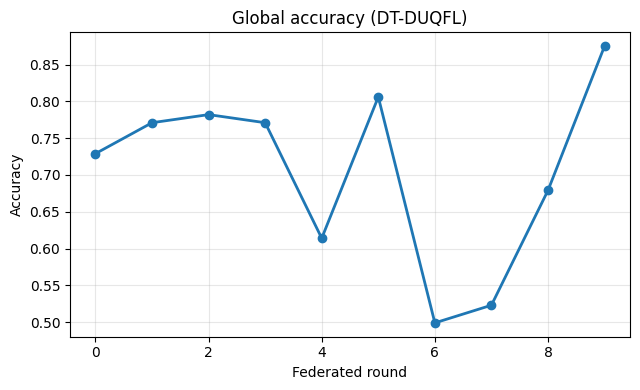

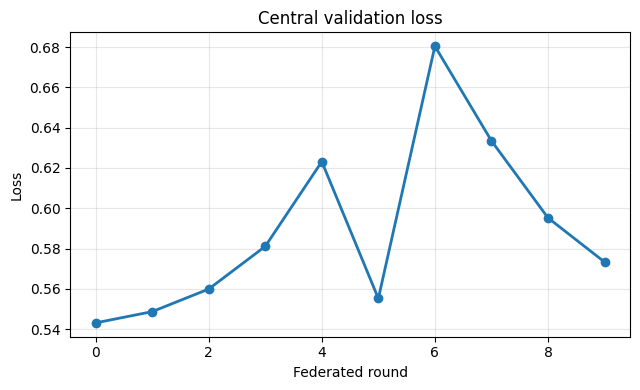

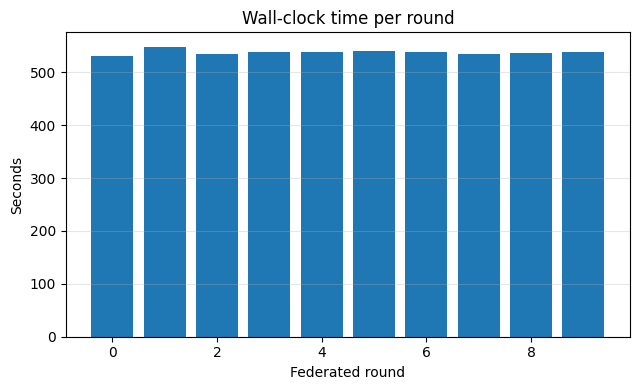

In [7]:
from training.loop import run_federated_training
from configs.base_config import use_teleportation as CFG_TEL, noise_preset, shots_used,aggregation
from training.metrics import metrics_init, metrics_log_round, metrics_finalize, compute_auc,metrics_summarize
from viz.plots import plot_accuracy_curve, plot_val_loss, plot_time_per_round, plot_fidelity_vs_delta_acc, plot_beta_hist, plot_client_fairness_last_round
# Initialize metrics store once
metrics_store = metrics_init(
    log_path=os.path.join(drive_root, "teleport_metrics_Perturb_shrink.csv")
)

#new
from ml import optimizers as mlopt
from configs.base_config import drive_root
import os

mlopt.meta_trace_enable(
    path=os.path.join(drive_root, "meta_trace.csv"),  # or None to skip CSV
    every=5                                           # print every 5 callbacks
)

###########
global_acc, clients_train, clients_test, round_times, val_losses, info_last = run_federated_training(
    clients=clients,
    num_federated_layers=num_federated_layers,
    num_deep_unfolding_iterations=num_deep_unfolding_iterations,
    initial_learning_rate=initial_learning_rate,
    initial_perturbation=initial_perturbation,
    num_features=num_features,
    best_client_csv_file=best_client_csv_file,
    global_csv_file=global_csv_file,
    local_csv_file=local_csv_file,
    validation_csv_file=validation_csv_file,
    test_sequences=test_sequences,
    test_labels=test_labels,
    X_val=X_val,
    y_val=y_val,
    use_teleportation=CFG_TEL,          # ← important
    noise_preset=noise_preset,
    shots_used=shots_used,
    metrics=metrics_store,   # <-- pass it in
    aggregation=aggregation           # <--- switch here
)

rows_np = metrics_finalize(metrics_store)   # if you need the in-memory array
#summary = metrics_summarize(metrics_store)  # prints a concise summary, returns a dict

# quick visuals
rounds = list(range(len(global_acc)))
plot_accuracy_curve(rounds, global_acc, label="Global accuracy (DT-DUQFL)")
plot_val_loss(rounds, val_losses, label="Central validation loss")
plot_time_per_round(rounds, round_times)

if info_last is not None:
    # this uses "last" round's info; in your logger you kept per-round arrays; adapt if needed
    pass
